In [1]:
from pathlib import Path
import os
from hyperct import Complex
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._curvatures import b_curvatures_hn_ij_c_ij
from data.data_levelset_geometric_shapes.extract_and_process_interface_points import read_data


def HNdC_ijk(e_ij, l_ij, l_jk, l_ik):
    lengths = [l_ij, l_jk, l_ik]
    # Sort the list, python sorts from the smallest to largest element:
    lengths.sort()
    # We must have use a ≥ b ≥ c in floating-point stable Heron's formula:
    a = lengths[2]
    b = lengths[1]
    c = lengths[0]
    A = (1/4.0) * np.sqrt((a + (b + c)) * (c - (a - b)) * (c + (a - b)) * (a + (b - c)) )
    # Dual weights (scalar):
    w_ij = (1/8.0) * (l_jk**2 + l_ik**2 - l_ij**2)/A
    
    # Mean normal curvature (1x3 vector):
    hnda_ijk =  w_ij * e_ij # curvature from this edge jk in tringle ijk with w_jk = 1/2 cot(theta_i^jk)

    # Dual areas
    h_ij =  0.5 * l_ij
    b_ij = abs(w_ij) * l_ij  # = ||0.5 cot(theta_i^jk)|| * 0.5*l_ij
    c_ijk = 0.5 * b_ij * h_ij
    return hnda_ijk, c_ijk


def plot_intersections(axes, intersections, corners, plot_thick):
   number_of_inter = len(intersections)
   for idx in range(0, number_of_inter):
      this_inter       = intersections[idx]
      this_inter_faces = find_cell_faces(this_inter, corners)
      for nxt_idx in range(idx+1, number_of_inter):
         next_inter       = intersections[nxt_idx]
         next_inter_faces = find_cell_faces(next_inter, corners)

         if len(this_inter_faces.intersection(next_inter_faces)) > 0:
            if plot_thick:
               axes.plot( [this_inter[0], next_inter[0]], [this_inter[1], next_inter[1]], [this_inter[2], next_inter[2]], marker="x", markersize=1.5, linewidth=0.5, color = "red")
            else:
               axes.plot( [this_inter[0], next_inter[0]], [this_inter[1], next_inter[1]], [this_inter[2], next_inter[2]], marker="x", markersize=0.25, linewidth=0.25, color = "red")

def find_cell_faces(intersection_point, cell_corners):
    all_sides = [
       0 if intersection_point[0] == cell_corners[0][0] else None,
       1 if intersection_point[0] == cell_corners[6][0] else None,
       2 if intersection_point[1] == cell_corners[0][1] else None,
       3 if intersection_point[1] == cell_corners[6][1] else None,
       4 if intersection_point[2] == cell_corners[0][2] else None,
       5 if intersection_point[2] == cell_corners[6][2] else None
       ]
    #return set([side for side in all_sides if side is not None])
    return [side for side in all_sides if side is not None]


def f_ijk(nverts):
    # Returns the F_ijk matrix of faces depending on the number of vertices 
    F_ijk = np.zeros([nverts - 2, 3], dtype=int)
    if nverts == 3:
        F_ijk[:] = [0, 1, 2]
    elif nverts == 4:  # 2 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 3]
    elif nverts == 5:  # 3 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 4]
        F_ijk[2, :] = [2, 3, 4]
    elif nverts == 6:  # 4 simplices
        F_ijk[0, :] = [0, 1, 2]
        F_ijk[1, :] = [0, 2, 4]
        F_ijk[2, :] = [2, 3, 4]
        F_ijk[3, :] = [0, 3, 4]
        
    return F_ijk

def assign_incides(intersections, corners):
    # Return ordered points and connectivity matrix E_ij
    nverts = intersections.shape[0]  # number of intersection in current cell
    pf_indices = []
    pind = 0
    pind_order = []  # or int dtype array of size intersections.shape[0] 
    # Compute the faces 
    for p in intersections:
        pi = find_cell_faces(p, corners)
        pf_indices.append(pi)
        
    # Find the correct order of points of the intersections
    pind_order.append(0)  # Arbitarily select the first point
    pind = 0  # Previous index
    cf = pf_indices[0][0]  # current face
    while len(pind_order) < nverts:  
        for i in range(len(pf_indices)):
            if i == pind:
                continue
            ci = pf_indices[i]
            if cf == ci[0]:
                pind_order.append(i)
                cf = ci[1]  # Move on to new face
                pind = i  # Make i the previous index for the next loop
                break  # Break out of current for loop, continue to next vertex
            elif cf == ci[1]:
                pind_order.append(i)
                cf = ci[0]  # Move on to new face
                pind = i  # Make i the previous index for the next loop
                break  # Break out of current for loop, continue to next vertex
                
    F_ijk = f_ijk(nverts)  # Triangles present in current cell
    return pind_order, f_ijk(nverts)


def glob_hash(cell_corners_and_intersections):
    # Hash table of intersection indices
    # This is a global hash table of all intersections points. 
    # If computing only one local cell is desired, then at minimum 
    # the 9 surrounding cells need to be included for curvature to 
    # have physical meaning.
    points_hash = {}
    points_glob = []  # or a n x 3 array, where n is the total number of points    
    i = 0
    for index, c in enumerate(cell_corners_and_intersections):
        corners       = c["Corners"]
        intersections = c["Intersections"]
        for p in intersections:
            try:
                points_hash[tuple(p)]
            except KeyError:
                points_hash[tuple(p)] = i
                i = i + 1
                points_glob.append(p)  # or set row i vector equal to p
        
    points_glob = np.array(points_glob)  # convert list of points to array
    return points_hash, points_glob

def graph_e_ij(nverts):
    # Returns the E_ij graph of edges depending on the number of vertices 
    # use std::set for the final version
    if nverts == 3:
        E_ij = [[1, 2],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1],  # edges connected to vertex 2
               ] 
    elif nverts == 4:  # 2 simplices
        E_ij = [[1, 2, 3],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3],  # edges connected to vertex 2
                [0, 2],  # edges connected to vertex 3
               ] 
    elif nverts == 5:  # 3 simplices
        E_ij = [[1, 2, 4],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3, 4],  # edges connected to vertex 2
                [2, 4],  # edges connected to vertex 3
                [0, 2, 3],  # edges connected to vertex 4
               ] 
    elif nverts == 6:  # 4 simplices
        E_ij = [[1, 2, 4, 5],  # edges connected to vertex 0
                [0, 2],  # edges connected to vertex 1
                [0, 1, 3, 4],  # edges connected to vertex 2
                [2, 4],  # edges connected to vertex 3
                [0, 2, 3, 5],  # edges connected to vertex 4
                [0, 4],  # edges connected to vertex 5
               ] 
    return E_ij  #[0]

def E_ij_cells(cell_corners_and_intersections, points_hash, E_ij):
    for index, c in enumerate(cell_corners_and_intersections):
        corners       = c["Corners"]
        intersections = c["Intersections"]
        p, F_ijk_local, E_ij_local = assign_incides_graph(intersections, corners)
        points = intersections[p]  # Local points in correct order
        # get global incides
        for pi in p:  # Loop for the index of each local point
            i = points_hash[tuple(points[pi])]  # Get the global index
            for pj in E_ij_local[pi]:  # loop local connects
                if pi == pj:
                    continue
                j = points_hash[tuple(points[pj])]  # Find global index of connection j
                E_ij[i].add(j)
    return E_ij

def assign_incides_graph(intersections, corners):
    # Return ordered points and connectivity matrix E_ij
    nverts = intersections.shape[0]  # number of intersection in current cell
    pf_indices = []
    pind = 0
    pind_order = []  # or int dtype array of size intersections.shape[0] 
    # Compute the faces 
    for p in intersections:
        pi = find_cell_faces(p, corners)
        pf_indices.append(pi)
        
    # Find the correct order of points of the intersections
    pind_order.append(0)  # Arbitarily select the first point
    pind = 0  # Previous index
    cf = pf_indices[0][0]  # current face
    while len(pind_order) < nverts:  
        for i in range(len(pf_indices)):
            if i == pind:
                continue
            ci = pf_indices[i]
            if cf == ci[0]:
                pind_order.append(i)
                cf = ci[1]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
            elif cf == ci[1]:
                pind_order.append(i)
                cf = ci[0]  # move on to new face
                pind = i  # Make i the previous index for the next loop
                break
                
    F_ijk = f_ijk(nverts)  # Triangles present in current cell
    E_ij = graph_e_ij(nverts)  # Edges present in current cell
    
    return pind_order, F_ijk, E_ij

def triangulate_cells(cell_corners_and_intersections):
    E_ij = []
    points_hash, points_glob = glob_hash(cell_corners_and_intersections)
    for i in range(points_glob.shape[0]):  # for the number of points currently in global pool
        E_ij.append(set())

    
    #ncells = len(cell_corners_and_intersections)  # Number of cells currently under consideration
    #for i in range(ncells):
    # Compute the hash table of all points currently in cell_corners_and_intersections:
    points_hash, points_glob = glob_hash(cell_corners_and_intersections)

    # For each cell, 
    E_ij = E_ij_cells(cell_corners_and_intersections, points_hash, E_ij)
    
    return points_hash, points_glob, E_ij



In [2]:
filename = Path("../../ddgclib/data_levelset_geometric_shapes/sphere_coarse/extraction_data_0.000000.txt")
result_folder = Path("../../ddgclib/data_levelset_geometric_shapes/X_intersections_sphere_coarse")
plot_single_cells = False

# Create the result folder
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [3]:
# Read and plot the data
corners_and_intersections = read_data(filename)
#unique_intersections = extract_and_save_unique_intersection_points(corners_and_intersections, result_folder)
#plot_and_save_levelset_points(corners_and_intersections, result_folder)
#plot_unique_intersections(unique_intersections, result_folder)
#plot_intersection_points(corners_and_intersections, result_folder, plot_single_cells)

cell_corners_and_intersections = corners_and_intersections
def intersection_is_found(intersection, ref_intersections):
    return any([all([np.abs(coord - coord_ref) <= 1e-14 for coord, coord_ref in zip(intersection, ref_inter)]) for ref_inter in ref_intersections])
    # Get unique intersections
all_intersections    = [inter for data in cell_corners_and_intersections for inter in data["Intersections"]]
unique_intersections = np.unique(np.array(all_intersections), axis=0)
f_ijk(3), f_ijk(4), f_ijk(5), f_ijk(6)

Total number of cells          :  128
Total number of intersections  :  504
Total number of levelset points:  128


(array([[0, 1, 2]]),
 array([[0, 1, 2],
        [0, 2, 3]]),
 array([[0, 1, 2],
        [0, 2, 4],
        [2, 3, 4]]),
 array([[0, 1, 2],
        [0, 2, 4],
        [2, 3, 4],
        [0, 3, 4]]))

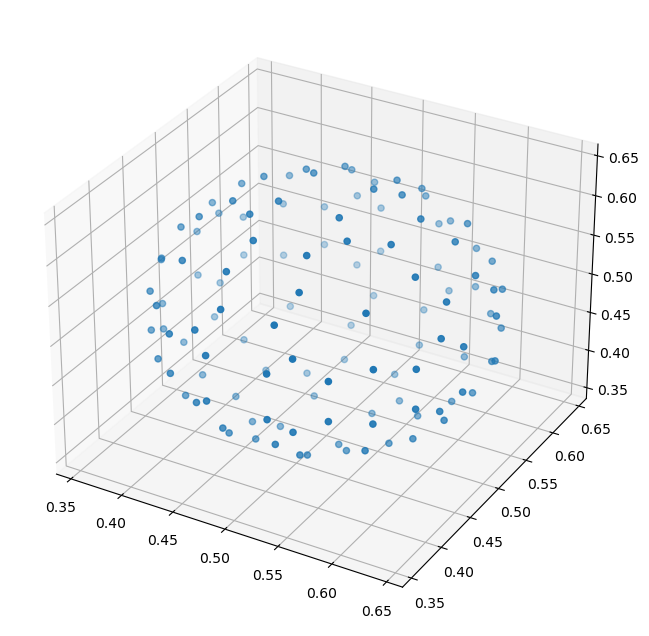

In [40]:
lpoints = []
for p in cell_corners_and_intersections:
    lpoints.append(p['Levelset'][0])

lpoints = np.array(lpoints)

#
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
x, y, z = lpoints[:, 0], lpoints[:, 1], lpoints[:, 2]
ax.scatter(x, y, z)
plt.show()

<IPython.core.display.Javascript object>


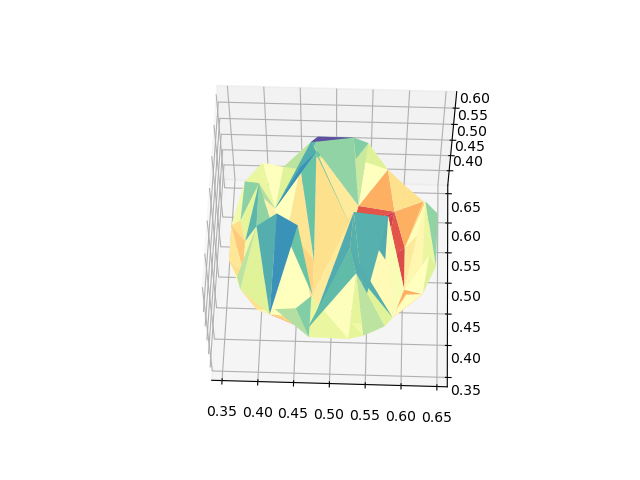

In [65]:
import scipy.spatial 
tri = scipy.spatial.Delaunay(lpoints)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=plt.cm.Spectral)
plt.show()

area:  34.64101615137756
volume:  17.453559924999308


<IPython.core.display.Javascript object>


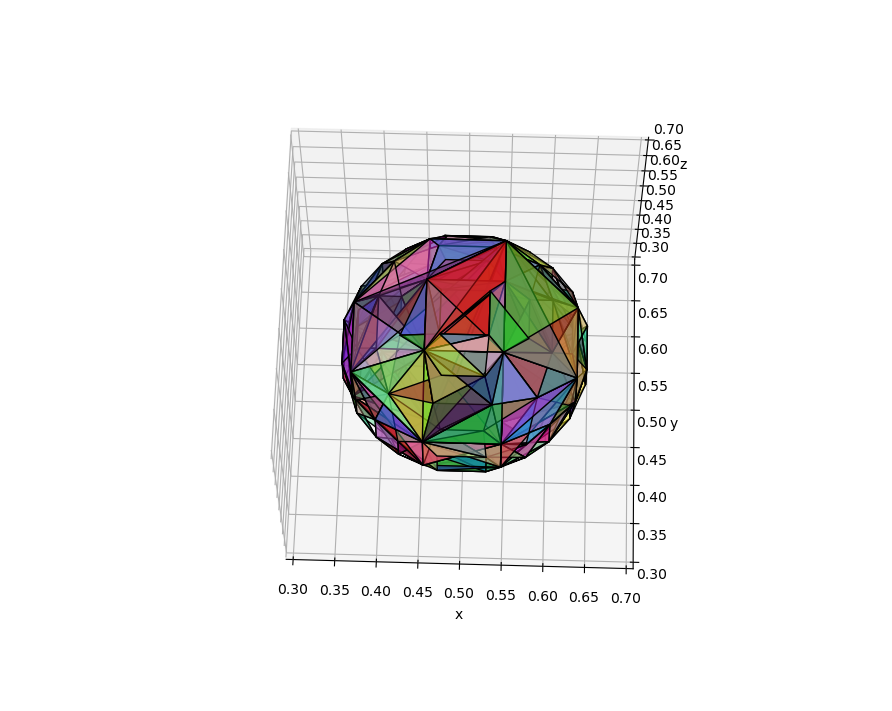

/tmp/ipykernel_85790/1053541511.py:29: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  face.set_color(mpl.colors.rgb2hex(sp.rand(3)))


In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import numpy as np
import scipy as sp

#
indices = tri.simplices
faces = tri.points[indices]
#

print('area: ', hull.area)
print('volume: ', hull.volume)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.dist = 30
#ax.azim = -140
ax.set_xlim([0.3, 0.7])
ax.set_ylim([0.3, 0.7])
ax.set_zlim([0.3, 0.7])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for f in faces:
    face = a3.art3d.Poly3DCollection([f])
    face.set_color(mpl.colors.rgb2hex(sp.rand(3)))
    face.set_edgecolor('k')
    face.set_alpha(0.5)
    ax.add_collection3d(face)

plt.show()

<IPython.core.display.Javascript object>


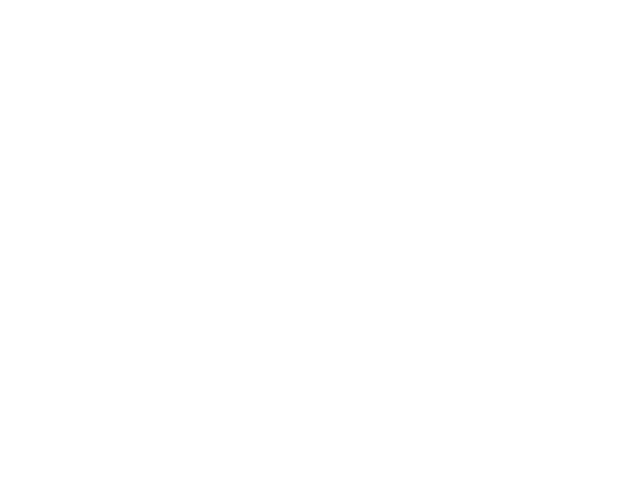

<IPython.core.display.Javascript object>


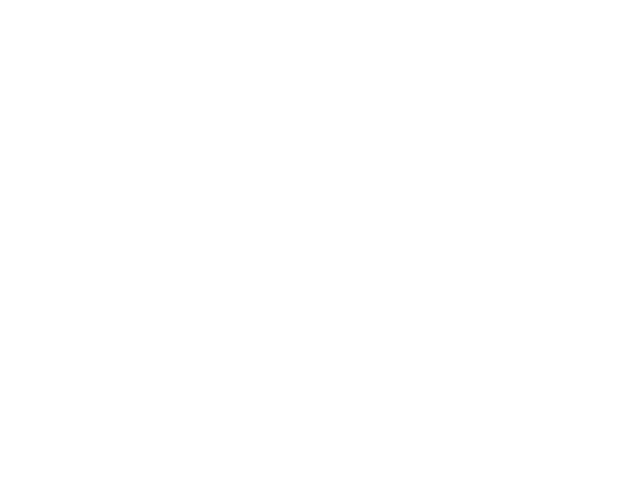

In [77]:
%matplotlib notebook
HC = Complex(3)
#HC.vf_to_vv(tri.points, tri.simplices)
#dV = HC.boundary_d(HC.V)
fig = plt.figure()
HC.vf_to_vv(tri.points, tri.simplices)
dV = HC.boundary_d(HC.V)
HC.plot_complex()
plt.show()

In [82]:
len(HC_curvatures_sessile(HC, bV, r, theta_p, printout=0))

13

In [89]:
r = 0.15 # Radius of the tube (20 mm)
theta_p = 20 * np.pi/180.0  # Three phase contact angle
r = np.array(r, dtype=np.longdouble)
bV = set([])

(HNdA_i, HNdA_ij, HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
            HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
            Theta_i_cache) = HC_curvatures_sessile(HC, bV, r, theta_p, printout=0)
HNdA_ij

[array([[ 0.        ,  0.        ,  0.        ],
        [ 0.02190463,  0.02526225, -0.02190463],
        [ 0.0922133 ,  0.02818039,  0.02818039],
        [ 0.00305921,  0.00199771, -0.00057318],
        [-0.08345956, -0.07236691, -0.07236691],
        [-0.02818039, -0.0922133 ,  0.02818039],
        [-0.00199771, -0.00305921, -0.00057318],
        [-0.0022545 ,  0.01203295, -0.00785769],
        [-0.02875697,  0.02875697, -0.09410002]], dtype=float128),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.17532672e-02,  5.67433477e-02, -1.04282693e-01],
        [ 1.00078494e-01,  0.00000000e+00,  0.00000000e+00],
        [-9.22132982e-02, -2.81803860e-02, -2.81803860e-02],
        [-4.29361165e-21, -1.65299806e-21,  3.03787310e-21],
        [ 3.21104133e-02,  8.58108431e-02, -9.80235750e-02],
        [ 1.44408212e-02, -6.71521183e-03,  5.87856532e-03]],
       dtype=float128),
 array([[ 0.        ,  0.        ,  0.        ],
        [ 0.02685346, -0.03795363,  0.01

In [ ]:
n = len(cell_corners_and_intersections)  # Total number of cells for which to 
int_hndA_i = 0
for i in range(n):
    cell_i = i
    hndA_i = curvature_cell_i(cell_i, cell_corners_and_intersections)
    int_hndA_i += 2*hndA_i
    
int_hndA_i

In [ ]:
r = 0.15 # Radius of the tube (20 mm)
theta_p = 20 * np.pi/180.0  # Three phase contact angle
r = np.array(r, dtype=np.longdouble)

2*np.linalg.norm(int_hndA_i), 4*np.pi*r

In [91]:
HNdA_ij[0]
intHNdA_i = np.sum(HNdA_ij[0], axis=0)
intHNdA_i

array([-0.02747199, -0.07140915, -0.14101484], dtype=float128)

In [84]:
# Compute the curvatures at each vertex:
HNdA_i = np.sum(HNdA_ijk, axis=(1, 2))
######
#NOTE: the above line  is equivalent to (possibly easier in C++):
#HNdA_i = np.zeros([nverts, 3])
#for i in range(nverts):
#    for HNdA_jk in HNdA_ijk[i]:
#        for HNdA_k in HNdA_jk:
#            HNdA_i[i] += HNdA_k
######

C_i = np.sum(C_ijk, axis=(1, 2))

######
#NOTE: the above line is equivalent to (possibly easier in C++):
#C_i = np.zeros([nverts])
#for i in range(nverts):
#    for C_jk in C_ijk[i]:
#        for C_k in C_jk:
#            C_i[i] += C_k
######
HNdA_i.shape, C_i.shape

((126, 3), (126,))

In [81]:
def HC_curvatures_sessile(HC, bV, r, theta_p, printout=False):
    R = r / np.cos(theta_p)
    K_f = (1 / R) ** 2
    H_f = 2 / R  # 2 / R
    HNdA_ij = []
    HNdA_i = []
    HN_i = []
    C_ij = []
    K_H_i = []
    HNdA_i_Cij = []
    Theta_i = []

    N_i = []  # Temp cap rise normal

    HNdA_i_cache = {}
    HN_i_cache = {}
    C_ij_cache = {}
    K_H_i_cache = {}
    HNdA_i_Cij_cache = {}
    Theta_i_cache = {}

    for v in HC.V:
        #TODO: REMOVE UNDER NORMAL CONDITIONS:
        if 0:
            if v in bV:
                continue
        N_f0 = v.x_a - np.array([0.0, 0.0, 0.0])  # First approximation
        N_f0 = normalized(N_f0)[0]
        N_i.append(N_f0)
        F, nn = vectorise_vnn(v)
        # Compute discrete curvatures
        c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
        # Append lists
        HNdA_ij.append(c_outd['HNdA_ij'])
        HNdA_i.append(c_outd['HNdA_i'])
        #HNdA_ij_dot.append(np.sum(np.dot(c_outd['HNdA_ij'], c_outd['n_i'])))
        HN_i.append(c_outd['HN_i'])
        C_ij.append(c_outd['C_ij'])
        K_H_i.append(c_outd['K_H_i'])
        HNdA_i_Cij.append(c_outd['HNdA_ij_Cij'])
        Theta_i.append(c_outd['theta_i'])
        
        # CIT paper:
        if 0:
            c_outd2 = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
            HN_i_2.append(c_outd2['HN_i'])
            HNdA_i_list.append(c_outd2['HNdA_i'])
            C_ij_i_list.append(c_outd2['C_ij'])

        # Append chace
        HNdA_i_cache[v.x] = c_outd['HNdA_i']
        HN_i_cache[v.x] = c_outd['HN_i']
        C_ij_cache[v.x] = c_outd['C_ij']
        K_H_i_cache[v.x] = c_outd['K_H_i']
        HNdA_i_Cij_cache[v.x] = c_outd['HNdA_ij_Cij']
        Theta_i_cache[v.x] = c_outd['theta_i']

    if printout:
        print('.')
        print(f'HNdA_ij = {HNdA_ij}')
        print(f'HN_i = {HN_i}')
        print(f'C_ij = {C_ij}')
        print(f'K_H_i = {K_H_i}')
        print(f'HNdA_i_Cij = {HNdA_i_Cij}')
        print(f'Theta_i= {Theta_i}')
        print(f'np.array(Theta_i) in deg = {np.array(Theta_i) *180/np.pi}')
        print(f'np.array(Theta_i)/np.pi= {np.array(Theta_i) / np.pi}')
        rati = 2 * np.pi /np.array(Theta_i)
        rati = 2 * np.pi / (2 * np.pi - np.array(Theta_i))
        rati =  2 * np.pi / (2 * np.pi - np.array(Theta_i))
        rati =  (np.pi - np.array(Theta_i)/ 2 * np.pi )
        print(f' rati = { rati}')
        print(f'HNdA_i[1] * rati[1]  = {HNdA_ij[1] * rati[1] }')
        print(f'C_ij   = {C_ij }')
        print('.')
        print(f'HNdA_i_Cij = {HNdA_i_Cij}')

        print('-')
        print('Errors:')
        print('-')

        print(f'K_H_i - K_f = {np.array(K_H_i) - K_f}')
        print(f'HN_i  - H_f = {HN_i - H_f}')
        print(f'HNdA_i_Cij  - H_f = {HNdA_i_Cij - H_f}')

        #print(f'np.sum(C_ij) = {np.sum(C_ij)}')

    return (HNdA_i, HNdA_ij, HN_i, C_ij, K_H_i, HNdA_i_Cij, Theta_i,
            HNdA_i_cache, HN_i_cache, C_ij_cache, K_H_i_cache, HNdA_i_Cij_cache,
            Theta_i_cache)


# Older code below!

In [7]:
# Test the triangluation retrieved with hyperct library
HC = Complex(3)
i = 0
for pi in points_glob:
    for j in E_ij[i]:
        vi = HC.V[tuple(pi)]
        vj = HC.V[tuple(points_glob[j])]
        vi.connect(vj)
    i = i + 1
    
HC.plot_complex()

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


(<Figure size 640x480 with 0 Axes>, <Axes3D: >, None, None)

<Figure size 640x480 with 0 Axes>

# Next we need:

1. To determine the local integrated curvature $HN_i$ around each intersection vertex $v_i$.  
2. To find the dual areas $C_{ijk}$, especially of the local cell currently under consideration.
3. To determine the actual curvature actually used in the cell.


In [8]:
# Normal for _this_ sphere:
#N_f0 = v.x_a - np.array([0.5, 0.5, 0.5])  # First approximation

In [9]:
E_ij[0].intersection(E_ij[1])

{2, 3}

In [10]:
HNdA_i[i]

NameError: name 'HNdA_i' is not defined

In [11]:
len(E_ij), nverts

NameError: name 'nverts' is not defined

In [12]:

def curvature_tensors(points_glob, E_ij):
    # nverts is the total number of intersection points:
    nverts = points_glob.shape[0]  # scalar, number of intersection points
    # Initiate a `n x n x n x 3` array, this should ideally be a sparse array,
    # for simplicity I have initiated a numpy array with the correct 
    # dimensions:
    HNdA_ijk = np.zeros([nverts, nverts, nverts, 3]) 
    # For dual arages we need a `n x n x n` array, this should again ideally be a sparse array,
    # for simplicity I have initiated a numpy array with the correct 
    # dimensions:
    C_ijk = np.zeros([nverts, nverts, nverts]) 

    # Initiate vector of shape (number of intersection points, 3):
    HNdA_i = np.zeros(points_glob.shape)
    
    # Start main `for` loop for each intersection plot
    for i in range(nverts):
        #NOTE: THIS MUST BE REPLACED WITH THE LEVEL SET PLANE VECTOR:
        n_i = points_glob[i] - np.array([0.5, 0.5, 0.5])  # First approximation
        #######################################################################
        # Initiate
        HNdA_ij = np.zeros([len(E_ij), 3])
        for j in E_ij[i]:
            # Compute the intersection set of vertices i and j:
            e_i_int_e_j = E_ij[i].intersection(E_ij[j])  # Set of size 1 or 2
            e_ij = points_glob[j] - points_glob[i]  # Compute edge ij (1x3 vector)
            if len(e_i_int_e_j) == 1:  # boundary edge
                k = list(e_i_int_e_j)[0]  # Boundary edge index
                # Compute edges in triangle ijk
                e_ik = points_glob[k] - points_glob[i]
                e_jk = points_glob[k] - points_glob[j]
                # Find lengths (norm of the edge vectors):
                l_ij =  np.linalg.norm(e_ij)
                l_ik =  np.linalg.norm(e_ik)  #NOTE: l_ki = l_ik
                l_jk =  np.linalg.norm(e_jk)
                hnda_ijk, c_ijk = HNdC_ijk(e_ij, l_ij, l_jk, l_ik)
                # Save results
                HNdA_ijk[i][j][k] = hnda_ijk
                C_ijk[i][j][k] = c_ijk

            else:  #len(e_i_int_e_j) == 2 mathematically guaranteed:
                k = list(e_i_int_e_j)[0]  # index in triangle ijk
                l = list(e_i_int_e_j)[1]  # index in triangle ijl
                e_ik = points_glob[k] - points_glob[i]  # Compute edge ik (1x3 vector)

                # Discrete vector area:
                # Simplex areas of ijk and normals
                wedge_ij_ik = np.cross(e_ij,  e_ik)
                # If the wrong direction was chosen, choos the other:
                if np.dot(normalized(wedge_ij_ik)[0], n_i) < 0:
                    k_t = k
                    l_t = l
                    k = l_t
                    l = k_t
                    e_ij = points_glob[j] - points_glob[i]
                    e_ik = points_glob[k] - points_glob[i]

                # Compute dual for contact angle alpha
                e_jk = points_glob[k] - points_glob[j]
                #wedge_ij_ik = np.cross(e_ij, e_ik)
                # Find lengths (norm of the edge vectors):
                l_ij =  np.linalg.norm(e_ij)
                l_ik =  np.linalg.norm(e_ik)  #NOTE: l_ki = l_ik
                l_jk =  np.linalg.norm(e_jk)
                hnda_ijk, c_ijk = HNdC_ijk(e_ij, l_ij, l_jk, l_ik)

                # Contact angle beta
                e_il = points_glob[l] - points_glob[i]
                e_jl = points_glob[l] - points_glob[j]
                l_il =  np.linalg.norm(e_il)  #NOTE: l_ki = l_ik
                l_jl =  np.linalg.norm(e_jl)
                hnda_ijl, c_ijl = HNdC_ijk(e_ij, l_ij, l_jl, l_il)

                # Save results
                HNdA_ijk[i][j][k] = hnda_ijk
                C_ijk[i][j][k] = c_ijk
                HNdA_ijk[i][j][l] = hnda_ijl
                C_ijk[i][j][l] = c_ijl
                
    return HNdA_ijk, C_ijk

HNdA_ijk, C_ijk = curvature_tensors(points_glob, E_ij)
HNdA_ijk, C_ijk

(array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [-0.00129967,  0.00199954,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.00010593, -0.00029914],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         ...,
 
         [[ 

# Last step!

Finally we need to collect the curvature and dual area around each vertex $i$ and then we can find the edges in the primary cell under consideration and compute the average curvature there.

In [13]:
HNdA_ijk[0], C_ijk[0]

(array([[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [-0.00129967,  0.00199954,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.00010593, -0.00029914],
         [ 0.        ,  0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        ...,
 
        [[ 0.        ,  0.        

In [14]:
# Compute the curvatures at each vertex:
HNdA_i = np.sum(HNdA_ijk, axis=(1, 2))
######
#NOTE: the above line  is equivalent to (possibly easier in C++):
#HNdA_i = np.zeros([nverts, 3])
#for i in range(nverts):
#    for HNdA_jk in HNdA_ijk[i]:
#        for HNdA_k in HNdA_jk:
#            HNdA_i[i] += HNdA_k
######

C_i = np.sum(C_ijk, axis=(1, 2))

######
#NOTE: the above line is equivalent to (possibly easier in C++):
#C_i = np.zeros([nverts])
#for i in range(nverts):
#    for C_jk in C_ijk[i]:
#        for C_k in C_jk:
#            C_i[i] += C_k
######
HNdA_i.shape, C_i.shape

((126, 3), (126,))

In [15]:
HNdA_i

array([[ 1.59136128e-02,  1.56421013e-02,  0.00000000e+00],
       [ 1.51874008e-02,  4.02529256e-03, -2.90754376e-06],
       [ 1.56490779e-02,  7.80886827e-03,  4.58207015e-03],
       [ 1.56490779e-02,  7.80886827e-03, -4.58207015e-03],
       [ 1.49843610e-02,  4.39603190e-03,  7.25232809e-03],
       [ 1.51751355e-02,  3.46944695e-18,  4.02247891e-03],
       [ 1.65558900e-02,  1.75983055e-04,  1.61834111e-02],
       [ 5.61555046e-02,  3.03576608e-18,  5.88650184e-06],
       [ 1.48261857e-02,  4.35913674e-03, -7.21608900e-03],
       [ 1.54913874e-02, -3.25260652e-19, -4.09502852e-03],
       [ 1.71981672e-02,  3.68628739e-18, -1.67247208e-02],
       [ 1.56490779e-02, -4.58207015e-03,  7.80886827e-03],
       [ 1.51874008e-02, -4.02529256e-03, -2.90754376e-06],
       [ 1.49843610e-02, -7.25232809e-03,  4.39603190e-03],
       [ 1.48261857e-02, -4.35913674e-03, -7.21608900e-03],
       [ 1.56490779e-02, -7.80886827e-03, -4.58207015e-03],
       [ 1.65558900e-02, -1.61834111e-02

In [16]:
C_i #- np.sum(C_ijk, axis=(1, 2))

array([0.00068144, 0.00469668, 0.00331914, 0.00331914, 0.00427206,
       0.00293753, 0.00315498, 0.00396656, 0.00398059, 0.0002183 ,
       0.00562851, 0.00503792, 0.00469668, 0.00255328, 0.00398059,
       0.00331914, 0.00315498, 0.00469668, 0.00562851, 0.00255328,
       0.00255328, 0.00643785, 0.00643785, 0.00643785, 0.00643785,
       0.00643785, 0.00643785, 0.00305257, 0.00315498, 0.0002183 ,
       0.00305257, 0.00068144, 0.0002183 , 0.00228671, 0.00643785,
       0.00643785, 0.00643785, 0.00305257, 0.00643785, 0.00643785,
       0.00315498, 0.00331914, 0.00643785, 0.00255328, 0.00469668,
       0.00293753, 0.00503792, 0.00315498, 0.00396656, 0.0002183 ,
       0.00474645, 0.00068144, 0.00315498, 0.00228671, 0.0002183 ,
       0.00562851, 0.00228671, 0.0002183 , 0.00414633, 0.00414633,
       0.00305257, 0.0002183 , 0.00228671, 0.0002183 , 0.00068144,
       0.00427206, 0.00562851, 0.00474645, 0.00315498, 0.00315498,
       0.00293753, 0.00396656, 0.0002183 , 0.00427206, 0.00469

In [17]:
# Find the contributions that need to be added here to each cell in the current vertex
# use the edge 
i_cell = 0
corners       = cell_corners_and_intersections[i_cell]["Corners"]
intersections = cell_corners_and_intersections[i_cell]["Intersections"]
nverts = intersections.shape[0]
local_verts = set()
for p in intersections:
   # print(points_hash[tuple(p)])
    local_verts.add(points_hash[tuple(p)]) #= i
    
    
# Find the fraction of c_i in all c_ijk in cell:
#c_i_cell = np.zeros([nverts])  # Local dual areas, array of size number of intersection points
hndA_i = np.zeros([3])  # Curvature of current cell, a `1 x n` vector 
for i in list(local_verts):  # For each vertex
    c_i_cell = 0  # Local dual area for current i, scalar
    # Find the fraction of c_i in all c_ijk in cell:
    for j in E_ij[i]:
        e_i_int_e_j = E_ij[i].intersection(E_ij[j])  # Set of size 1 or 2
        ind_k = e_i_int_e_j.intersection(local_verts)
        if len(ind_k) == 1:
            k = list(ind_k)[0]
            c_i_cell += C_ijk[i, j, k]
        elif len(ind_k) == 2:
            k = list(ind_k)[0]
            c_i_cell += C_ijk[i, j, k]
            l = list(ind_k)[1]
            c_i_cell += C_ijk[i, j, l]
    
    # Compute the fraction dual area:
    frac_c_i = C_i[i]/c_i_cell
    
    # Compute the fraction curvature contributed by the current vertex i
    hndA_i += frac_c_i * HNdA_i[i]
    
hndA_i

array([0.16851428, 0.08325927, 0.01390179])

# Wrapping up


In [18]:
# Find the contributions that need to be added here to each cell in the current vertex
# use the edge 
i_cell = 0
def hndA_i_cell(i_cell, cell_corners_and_intersections, E_ij, C_i, HNdA_i):
    corners       = cell_corners_and_intersections[i_cell]["Corners"]
    intersections = cell_corners_and_intersections[i_cell]["Intersections"]
    nverts = intersections.shape[0]
    local_verts = set()
    for p in intersections:
       # print(points_hash[tuple(p)])
        local_verts.add(points_hash[tuple(p)]) #= i

    # Find the fraction of c_i in all c_ijk in cell:
    #c_i_cell = np.zeros([nverts])  # Local dual areas, array of size number of intersection points
    hndA_i = np.zeros([3])  # Curvature of current cell, a `1 x n` vector 
    for i in list(local_verts):  # For each vertex
        c_i_cell = 0  # Local dual area for current i, scalar
        # Find the fraction of c_i in all c_ijk in cell:
        for j in E_ij[i]:
            e_i_int_e_j = E_ij[i].intersection(E_ij[j])  # Set of size 1 or 2
            ind_k = e_i_int_e_j.intersection(local_verts)
            if len(ind_k) == 1:
                k = list(ind_k)[0]
                c_i_cell += C_ijk[i, j, k]
            elif len(ind_k) == 2:
                k = list(ind_k)[0]
                c_i_cell += C_ijk[i, j, k]
                l = list(ind_k)[1]
                c_i_cell += C_ijk[i, j, l]

        # Compute the fraction dual area:
        frac_c_i = C_i[i]/c_i_cell

        # Compute the fraction curvature contributed by the current vertex i
        hndA_i += frac_c_i * HNdA_i[i]
    
    return hndA_i 

hndA_i = hndA_i_cell(i_cell, cell_corners_and_intersections, E_ij, C_i, HNdA_i)
hndA_i

array([0.16851428, 0.08325927, 0.01390179])